# An "acoustic" binary

In this tutorial we will use the ``timing`` module of the ``astrolab`` package to study an acoustic equivalent of a binary star system. The ``timing`` module can be used to analyse time-series data, and extract information of the different frequencies present in the data and how they vary as a function of time.

In this experiment, we will consider a pair of speakers attached to a rotating rod, at different distances from the rod's centre. Each of these speakers produces a single tone of a unique frequency. Since the speakers are rotating, each of these tones is Doppler-shifted with respect to a stationary observer. We consider this to be an acoustic analog of an astronomical binary system, since when stars in such systems rotate about their mutual centre of mass, their spectral lines are also known to undergo the same changes in frequency. To a first approximation, these changes are identical to those in our optical system, provided the speed of light is replaced with the speed of sound in air.

By recording the sound, we will be able to determine the rotation speed, as well as the relative frequency shifts of each speaker over a cycle. From both these pieces of information, we will be able to obtain the ratio of the distances of these two speakers from the centre of rotation which, in the case of an actual binary star, would represent the ratio of the stars' masses.

In [1]:
# The following lines are required so that the local ``astrolab`` package can be recognised by Python. 
# This is only necessary if you haven't installed the ``astrolab`` package on your machine.

import os
import sys
sys.path.insert(0, os.path.abspath("../../.."))

In [2]:
# Loading the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from astrolab import timing as tim

## Loading the signal

We begin by loading a ``.wav`` file using the ``load_signal`` function of the ``timing`` module. In addition to accepting the filename of the audio file, this function also allows the user to "clip" a section of the file and return the data. This is particularly useful if the first and last few seconds have disturbances because the recording device was being turned on or off. In the following cell, we will load the demo audio file, clip it between 5 and 45 seconds, and print a log of the resulting signal (which shows a plot of the time-series).

The ``load_signal`` function returns three quantities: the sample-rate of the signal, which is the number of audio samples in one second of data, the time-stamps of each signal sample, and the actual signal itself. We store these values in appropriately named variables.

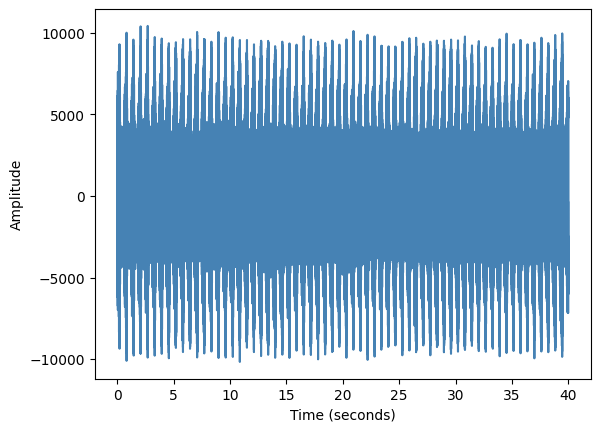

In [3]:
sr, times, sig = tim.load_signal(filename="./data/timing/doppler_4000Hz-6000Hz_speed1.wav", print_log=True, clip=[5,45])

## Obtaining frequency information from our signal

Let us first analyse our signal by looking at what frequencies are present in the overall signal. Since we know that this is a signal from a rotating object, we would expect the main frequency of each speaker to be present, along with a small range of frequencies about each of these frequencies, indicating the spread caused about each of them by the Doppler Effect. In the tutorial data used here, the speakers emit frequencies 4000 Hz and 6000 Hz respectively.

We can see the contributions of different frequencies by sending in our signal (and the samplerate) to the ``power_spectrum`` function of the ``timing`` module. This function returns the "amounts" of the different frequencies present in our signal. By default, it only shows the frequencies between 1000 Hz and 10,000 Hz. Since we know that both of our frequencies will be somewhere in the range 3000 Hz and 6000 Hz, we can change this range using the ``lowx`` and ``highx`` parameters of the ``power_series`` function.

6074.450000000001

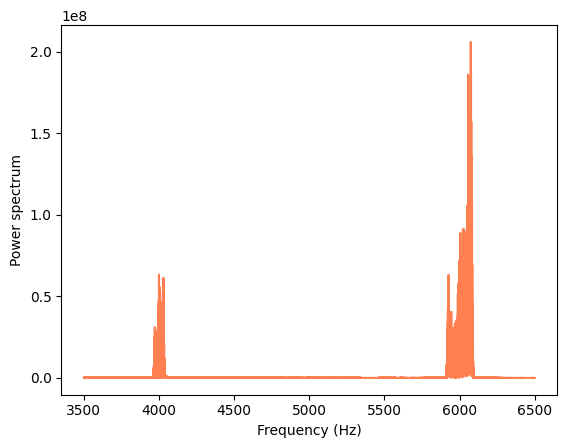

In [4]:
# Plotting the power spectrum of the entire signal

tim.power_spectrum(sig, samplerate=sr, print_log=True, lowx=3500, highx=6500)

### Analysing a single "chunk" of data

In the above cell we have studied all the possible frequencies that are present in the entire signal. However, for the purposes of this tutorial, we are more interested in knowing which frequency is dominant at a particular instant of time. This would be frequency detected by the observer from the rotating speaker _at that instant of time_.

In order to do this, we ideally want to break our signal into tiny "chunks" of some size, and then obtain the power spectrum of that chunk. As a concrete example, let us take a small section of the file we have loaded (say, 5000 data points) and store it in a variable called ``one_chunk`` and plot the resulting power spectrum.

We would like to know the dominant frequency of _each speaker_. Consequently, we only want to look at the dominant frequency in a smaller region around the "mean" frequency. This can again be set by adjusting the ``lowx`` and ``highx`` parameters.

The dominant frequencies for speaker 1 is 3974.4000000000005 and speaker 2 is 6057.600000000001


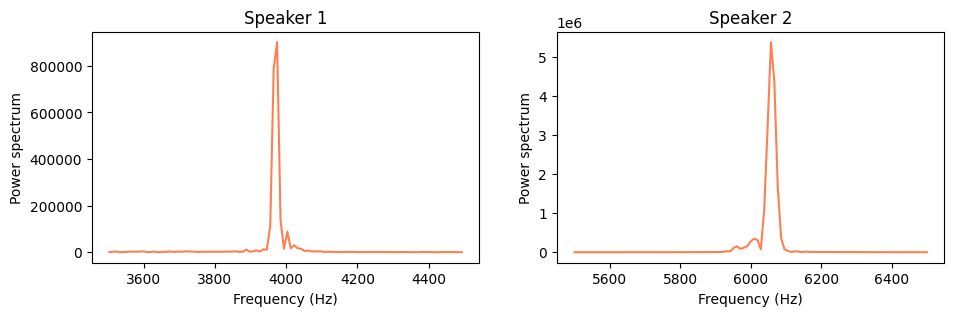

In [5]:
# Create a single chunk of 5000 data points, and plot its power spectrum

one_chunk = sig[0:5000]  # A single chunk

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3)) # Create a blank canvas for both plots

# For first speaker (4000 Hz)
axes[0].set_title("Speaker 1")
speaker1_dom = tim.power_spectrum(one_chunk, samplerate=sr, print_log=True, lowx=3500, highx=4500, fig=fig, ax=axes[0])

# For the second speaker (6000 Hz)
axes[1].set_title("Speaker 2")
speaker2_dom = tim.power_spectrum(one_chunk, samplerate=sr, print_log=True, lowx=5500, highx=6500, fig=fig, ax=axes[1])

print(f"The dominant frequencies for speaker 1 is {speaker1_dom} and speaker 2 is {speaker2_dom}")

The above plot shows that the power-spectrum peaks, in the range we are interested in for each speaker. In each case, the peak frequency is the _dominant_ frequency in that range, that is to say that it is the frequency that contributes most to the signal in these 5000 data points. Notice that the ``power_spectrum`` function also returns this dominant frequency. This will be useful when we want to know how this frequency changes as a function of time.

Now, we can choose some other range (say, the next 5000 chunks) and store it in another variable, say ``another_chunk``. We can then plot the power spectrum of this chunk and see where it peaks, as is done in the next cell. You should be able to see that the values of the dominant frequencies of both speakers has changed slightly from before.

The dominant frequencies for speaker 1 is 3984.0000000000005 and speaker 2 is 6076.800000000001


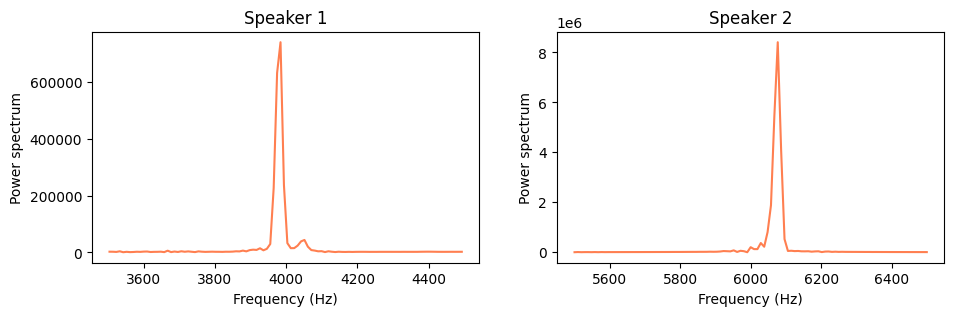

In [6]:
# Plotting the power spectrum of another chunk

another_chunk = sig[5000:10000]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3)) # Create a blank canvas for both plots

# For first speaker (4000 Hz)
axes[0].set_title("Speaker 1")
speaker1_dom = tim.power_spectrum(another_chunk, samplerate=sr, print_log=True, lowx=3500, highx=4500, fig=fig, ax=axes[0])

# For the second speaker (6000 Hz)
axes[1].set_title("Speaker 2")
speaker2_dom = tim.power_spectrum(another_chunk, samplerate=sr, print_log=True, lowx=5500, highx=6500, fig=fig, ax=axes[1])

print(f"The dominant frequencies for speaker 1 is {speaker1_dom} and speaker 2 is {speaker2_dom}")

### Automatically chunking the signal

Clearly, the signal in this chunk peaks at a different point. In this tutorial, we will be interested in observing the change of the dominant frequency at different time steps. Of course, the frequency does not abruptly change in intervals of 5000 samples. So, we will take a moving average, where the signal is broken into different chunks of ``size`` samples, the left-edges of which are separated by ``step`` samples. Consequently, each chunk has a lot of overlap with both the last and the next chunk. This will allow for a more continuous measurement of the change in the frequencies.

This process of "chunking" the signal can be performed using the ``chunk_signal`` function of the ``timing`` module. The ``size`` and ``step`` parameters can also be tuned in this function. We will discuss later how these values must be modified to properly analyse our data. 

The ``chunk_signal`` function returns two arrays, an array times denoting the average time-step at the middle of each chunk (this can be thought of as the time "at which" the dominant frequency was dominant, with the understanding that we are actually considering a small section of time, not a single instant), and the chunks themselves. Each chunk is an array with ``size`` elements.

In [7]:
# Chunking the signal

avg_t,chunks = tim.chunk_signal(times, sig)          # Chunk the signal

n_chunks = len(chunks)                               # Number of chunks

print("Total number of time-points is:", len(avg_t)) # Print out the total number of time-steps and chunks
print("The number of chunks is:", n_chunks)          # which should both be the same!

Total number of time-points is: 14984
The number of chunks is: 14984


### Finding the dominant frequency per chunk

We can now use the ``power_spectrum`` function on each chunk in the ``chunks`` array to get the dominant frequency in each chunk and store it in an array (which we will call ``dominant_freqs``). In order to do this, we will simply loop over all the chunks and apply the ``power_spectrum`` function to it. We will now only do it for speaker 1.

**Important!:** When applying the ``power_spectrum`` function in a loop, you must set  ``print_log=False``, since otherwise it will try to plot a single plot for every chunk which can very quickly overwhelm your computer and cause Python to crash. The ``print_log`` option is only to be used for individual chunks so that you can get a better sense of your data before putting it into a loop.

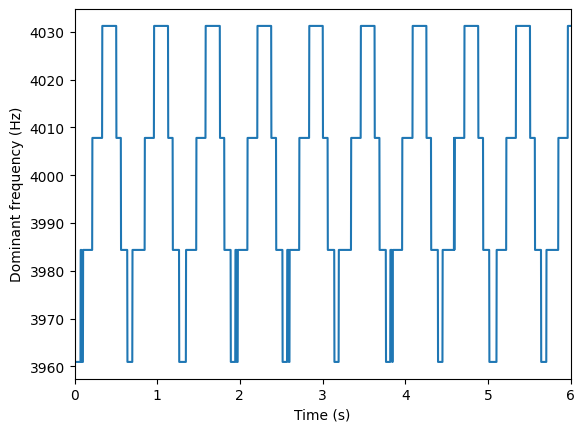

In [8]:
# Computing the dominant frequency for each chunk of speaker 1

dominant_freqs = np.zeros(n_chunks)   # Define an empty array to hold the dominant frequencies

for c in range(n_chunks):             # Loop over all chunks
    # Store the dominant frequency of each chunk
    dominant_freqs[c] = tim.power_spectrum(chunk=chunks[c], samplerate=sr, print_log = False, lowx=3500, highx=4500)

plt.plot(avg_t, dominant_freqs)       # Plot the dominant frequency of each chunk as a function of the chunk's "time"
plt.xlabel("Time (s)")                # Set the x-label
plt.ylabel("Dominant frequency (Hz)") # Set the y-label
plt.xlim(0,6)                         # Limit the x-range of the plot, to make it easier to read
plt.show()

In the above graph, it can clearly be seen that the dominant frequency shows some sort of periodic behaviour, increasing and decreasing over more-or-less constant intervals of time. This is a reflection of the fact that the rotation of the rod is periodic. By counting the period between the different peaks of the above graph, we can compute the time period of the rotating rod.

From this, using the fact that for circular motion, $$\frac{v}{r} = \frac{2 \pi}{T},$$ we can find the angular velocity of the rod. While this is not strictly needed for this tutorial, it is nevertheless interesting that this information can be obtained from a single signal recording.

## Getting the distance ratio for our "binary"

We will now try to get the ratio of the distances of each of the speakers from the centre of rotation. In the above example that we have done for a single speaker, we can show that the range of dominant frequencies goes between a minimum and maximum value. It is easy to show (and therefore left as an exercise) that for an object undergoing circular motion and emitting a frequency $f^{(1)}_0$ in its rest frame, the range of frequencies obtained is $$\frac{f^{(1)}_\text{max} - f^{(1)}_\text{min}}{f^{(1)}_0} = 2\times \left(\frac{v_1}{c_s}\right),$$ where $c_s$ is the speed of sound and $v_1$ is the speed of the first speaker. We can repeat the same analysis for the second speaker, and obtain a similar result  $$\frac{f^{(2)}_\text{max} - f^{(2)}_\text{min}}{f^{(2)}_0} = 2\times \left(\frac{v_2}{c_s}\right).$$

Since we know that the angular velocity of the speakers is constant in circular motion, this means that $v_1 = \omega r_1$ and $v_2 = \omega r_2$ where $\omega$ is the speakers' angular velocity. Using this, we can easily show that $$ \left(\frac{\Delta f^{(1)}}{f^{(1)}_0}\right) \times \left(\frac{f^{(2)}_0}{\Delta f^{(2)}}\right) = \frac{r_1}{r_2},$$ where we have denoted $\Delta f \equiv f_\text{max} - f_\text{min}$ for each speaker. Notice how the speed of sound no longer appears in this calculation.

We can now perform our analysis for both speakers and identify $\Delta f$ for both of them. We do this very simply, but plotting the same graph as the one above, and drawing horizontal lines at the appropriate level. Using these values we will compute the distance ratios.

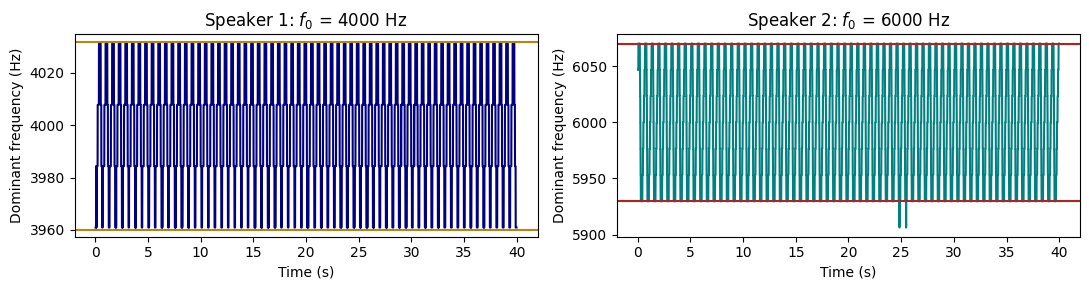

In [9]:
# Computing the dominant frequencies as a function of time for each speaker

speaker1_f0 = 4000
speaker2_f0 = 6000

speaker1_dominant_freqs = np.zeros(n_chunks)   # Define an empty array to hold the dominant frequencies for speaker 1
speaker2_dominant_freqs = np.zeros(n_chunks)   # Define an empty array to hold the dominant frequencies for speaker 2

for c in range(n_chunks):             # Loop over all chunks
    # Store the dominant frequency of each chunk for each speaker.
    # Note that the lowx and highx variables are different in each case, centred around the f0 for each speaker
    speaker1_dominant_freqs[c] = tim.power_spectrum(chunk=chunks[c], samplerate=sr, print_log = False, lowx=3500, highx=4500)
    speaker2_dominant_freqs[c] = tim.power_spectrum(chunk=chunks[c], samplerate=sr, print_log = False, lowx=5500, highx=6500)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3))  # Create a blank canvas to plot our graphs

axes[0].set_title(rf"Speaker 1: $f_0$ = {speaker1_f0} Hz")
axes[0].plot(avg_t, speaker1_dominant_freqs, color='navy')  # Plot the dominant frequency of each chunk
axes[0].set_xlabel("Time (s)")                              # Set the x-label
axes[0].set_ylabel("Dominant frequency (Hz)")               # Set the y-label

axes[1].set_title(rf"Speaker 2: $f_0$ = {speaker2_f0} Hz")
axes[1].plot(avg_t, speaker2_dominant_freqs, color='teal')  # Plot the dominant frequency of each chunk
axes[1].set_xlabel("Time (s)")                              # Set the x-label
axes[1].set_ylabel("Dominant frequency (Hz)")               # Set the y-label

speaker1_fmax = 4032 # These values are found 
speaker1_fmin = 3960 # through trial and error
speaker2_fmax = 6070
speaker2_fmin = 5930

axes[0].axhline(speaker1_fmin, color='darkgoldenrod')        # Plot horizontal lines for each guess
axes[0].axhline(speaker1_fmax, color='darkgoldenrod')        # The above values are adjusted so that the
                                                             # lines align with the maxima of each signal
axes[1].axhline(speaker2_fmin, color='firebrick')
axes[1].axhline(speaker2_fmax, color='firebrick')

plt.tight_layout()

Using our above relation, we can measure the distance ratio quite simply, since we have all the values needed in the formula $$ \left(\frac{\Delta f^{(1)}}{f^{(1)}_0}\right) \times \left(\frac{f^{(2)}_0}{\Delta f^{(2)}}\right) = \frac{r_1}{r_2}.$$

This is done in the following cell.

In [10]:
# Computing the distance ratio

distance_ratio = (speaker1_fmax - speaker1_fmin)/(speaker2_fmax - speaker2_fmin) * (speaker2_f0/speaker1_f0)

print("The distance ratio of speaker 1 and speaker 2 is", distance_ratio)

The distance ratio of speaker 1 and speaker 2 is 0.7714285714285714


## Identifying the "ideal" chunk-size

While the above analysis is not strictly incorrect, it has some issues. Firstly, if you look at the graph of dominant frequency as a function of time, you should be disappointed that the graph for speaker 1 looks quite "blocky", with constant values suddenly jumping by discrete steps.

The cause for this "blocky-ness" of our graphs is because of a "least-count" of our power-spectrum. The exact details of these are beyond the scope of this laboratory. For now, it is enough that you understand that for any signal that has a total time $t_\text{sig}$, there exists a minimum frequency difference that can be measured, the frequency "resolution" that is given by $$f_\text{res} = \frac{1}{t_\text{sig}}.$$

Thus, if we have a chunk with ``size`` samples, then the total duration of this signal and the minimum measurable frequency difference that can be measured is given by $$t_\text{sig} = \frac{\text{size}}{\text{sample rate}}, \quad \quad \implies \quad \quad f_\text{res} = \frac{\text{sample rate}}{\text{size}}.$$

Given that the sample rate is a constant, this tells us that the minimum measurable difference in frequencies is inversely proportional to the chunk "size". So we would ideally want as large a chunk size as possible in order to measure small variations in the frequency. 

Why then, you may ask, do we not keep ``size`` as large as possible? Remember that in our earlier analysis, we had made the assumption that the observed frequency does not change "too much" over a single chunk.  However, because our speaker is rotating, by choosing a very large ``size`` we will be averaging over too much of the speaker's trajectory in each chunk, and our assumption would no longer be valid. 

Consequently, it is important that we choose a chunk size that is appropriately large to see the variation in the frequency, but not too large that we average over too much of the speaker's motion as it rotates around the centre. We leave it as an exercise to the reader to change the chunk ``size`` to ``4096`` and run the previous cells and try to compute the ratio of arm-lengths. You should notice that a finer resolution gives you a much more accurate value of $\Delta f$ for each speaker. If all the calculations have been done well, you should be able to show that $$\frac{r_1}{r_2} \approx 0.55.$$

In order to automate the choice of chunk size, one can in principle choose a chunk size that ensures a certain number of "steps" between the highest and lowest frequencies. This is again left as an exercise to the reader.

## Discussion

This experiment analyses the audio spectra obtained from two speakers both rotating around a common centre with the same angular velocity. We have used these spectra to study the variation of a "spectal line", the dominant audio frequency received from each speaker as a function of time (or equivalently, the angular position of the speaker).

This mirrors what professional astronomers do when they observe spectral lines (of light) in the spectra of rotating binary stars. In exactly the same way, the ratio of the distances from the axis of rotation can be found. Astronomically, this distance is very important since by Newton's third law, the forces on each star are equal and opposite, meaning that their magnitudes must be equal. Using the equation for the centripetal force, this just means that $$|m_1 a_1| = |m_2 a_2| \quad \quad \implies \quad \quad m_1 \omega^2 r_1 = m_2 \omega^2 r_2.$$

From the above equation it can be seen that $$\frac{m_2}{m_1} = \frac{r_1}{r_2}.$$ In other words, the distance ratio can give us the mass ratio of the two orbiting stars. Thus, if one star's masses can be accurately computed through other means, its binary companion's mass can _also_ be computed, using a method similar to the one described in this tutorial!